<a href="https://colab.research.google.com/github/yurenianastya/xai_lab/blob/main/Yurenia_GradCAM_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
#Importing Libraries:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [215]:
def find_first_indices_by_classes(y_train, num_classes):
    class_indices = {}
    for class_id in range(num_classes):
        indices = np.where(y_train == class_id)[0]
        index = indices[0] if indices.size > 0 else None
        class_indices[class_id] = index
    return class_indices

In [49]:
#Defining GradCAM Function:
def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    return cam

# Emognition


Saving 22.csv to 22 (10).csv


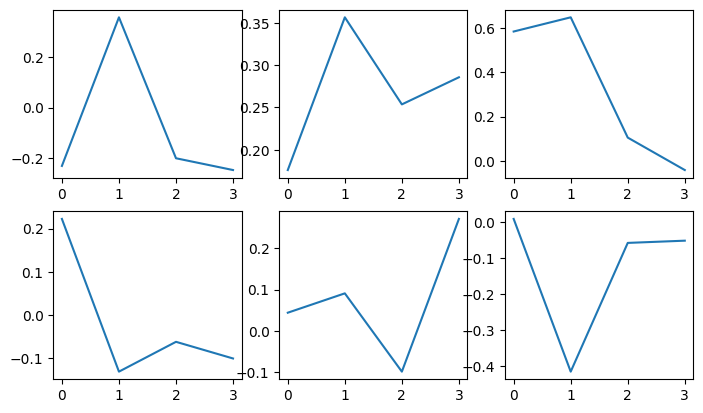

In [183]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

uploaded = files.upload()

# X, y, meta_data = load_classification("Strawberry", return_metadata=True)

features = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']
sequence_length = 20

df = pd.read_csv('22.csv')
df = df.dropna()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

X = np.log1p(df[features])
y = df['emotion']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(label_encoder.classes_))
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_sequences = np.array([X[i:i + sequence_length] for i in range(len(X) - sequence_length + 1)])

y_one_hot = tf.keras.utils.to_categorical(y_encoded)
y_one_hot = y_one_hot[:len(X_sequences)]

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_one_hot, test_size=0.4, shuffle=False)

sequence_length = 20
num_features = len(features)

fig, axs = plt.subplots(2,3)
fig.subplots_adjust(left=0, right = 1)
axs[0][0].plot(X_sequences[0][0])
axs[0][1].plot(X_sequences[1][0])
axs[0][2].plot(X_sequences[2][0])

axs[1][0].plot(X_sequences[3][0])
axs[1][1].plot(X_sequences[4][0])
axs[1][2].plot(X_sequences[5][0])

fig.show()


In [184]:
print(X.shape)
print(X_sequences.shape)
print(y)

(21423, 4)
(21404, 20, 4)
0        DISGUST
1        DISGUST
2        DISGUST
3        DISGUST
4        DISGUST
          ...   
21418        AWE
21419        AWE
21420        AWE
21421        AWE
21422        AWE
Name: emotion, Length: 21423, dtype: object


Building a Simple Convolutional Neural Network (CNN) Model:

In [195]:
num_classes = len(np.unique(label_encoder.classes_))
print(num_classes)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_sequences.shape[1], X_sequences.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['accuracy'])

10


Training the Model:

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_one_hot, test_size=0.4, shuffle=False)

model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
402/402 [==============================] - 2s 5ms/step - loss: 0.0576 - accuracy: 0.5617 - val_loss: 0.1200 - val_accuracy: 0.0118
Epoch 2/10
402/402 [==============================] - 3s 6ms/step - loss: 0.0573 - accuracy: 0.5688 - val_loss: 0.1231 - val_accuracy: 0.0070
Epoch 3/10
402/402 [==============================] - 2s 5ms/step - loss: 0.0568 - accuracy: 0.5727 - val_loss: 0.1238 - val_accuracy: 0.0109
Epoch 4/10
402/402 [==============================] - 2s 6ms/step - loss: 0.0568 - accuracy: 0.5714 - val_loss: 0.1214 - val_accuracy: 0.0123
Epoch 5/10
402/402 [==============================] - 2s 5ms/step - loss: 0.0559 - accuracy: 0.5786 - val_loss: 0.1236 - val_accuracy: 0.0103
Epoch 6/10
402/402 [==============================] - 2s 4ms/step - loss: 0.0562 - accuracy: 0.5724 - val_loss: 0.1272 - val_accuracy: 0.0035
Epoch 7/10
402/402 [==============================] - 2s 4ms/step - loss: 0.0559 - accuracy: 0.5761 - val_loss: 0.1231 - val_accuracy: 0.0110
Epoch 

In [198]:
train_results = model.evaluate(X_train, y_train)
test_results = model.evaluate(X_test, y_test)
train_results, test_results

268/268 [==============================] - 1s 2ms/step - loss: 0.1250 - accuracy: 0.0095


([0.0539359487593174, 0.636271595954895],
 [0.12499595433473587, 0.009460406377911568])

Generate GradCAM Heatmap for emotions:

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
tf.Tensor(
[[8.0503428e-01 1.1940961e-02 2.5362818e-04 1.3431278e-01 5.5426604e-04
  2.5739338e-02 4.6651342e-04 1.8031374e-02 1.0786406e-03 2.5882127e-03]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


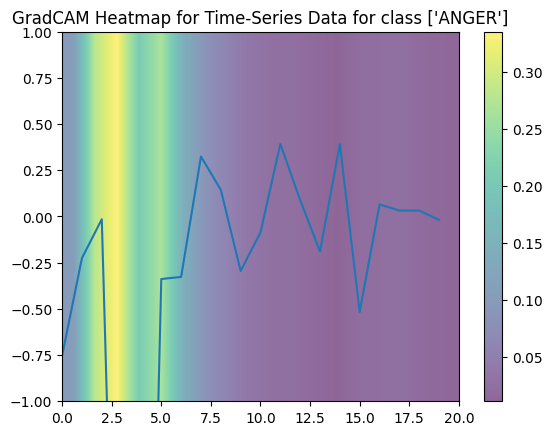

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tf.Tensor(
[[0.01741764 0.05927711 0.00700382 0.14235176 0.00405524 0.0158695
  0.00443744 0.02447969 0.63178164 0.09332617]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


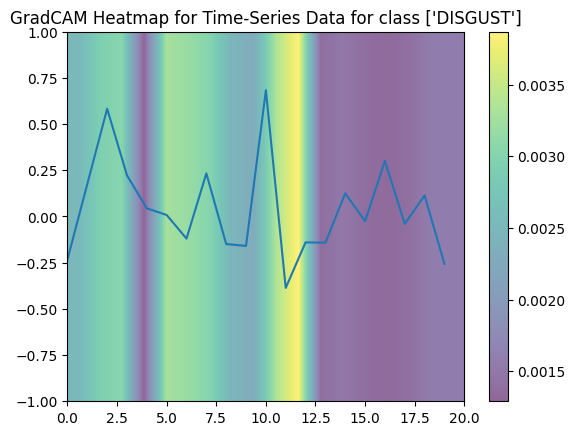

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tf.Tensor(
[[0.20385273 0.11475916 0.01339234 0.15723784 0.01503805 0.11108799
  0.01183622 0.14019652 0.09192351 0.1406756 ]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


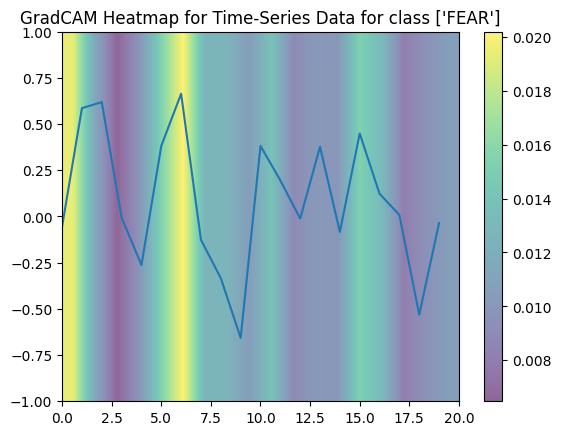

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
tf.Tensor(
[[0.20023008 0.08890045 0.0060127  0.11800499 0.00724506 0.00347861
  0.007825   0.33367148 0.1889141  0.04571752]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


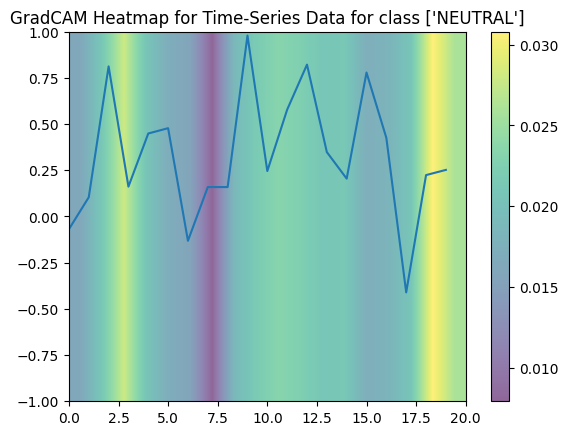

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
tf.Tensor(
[[0.19345565 0.13366228 0.00630806 0.1125206  0.00915516 0.12388267
  0.00643996 0.3339694  0.0346514  0.04595488]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


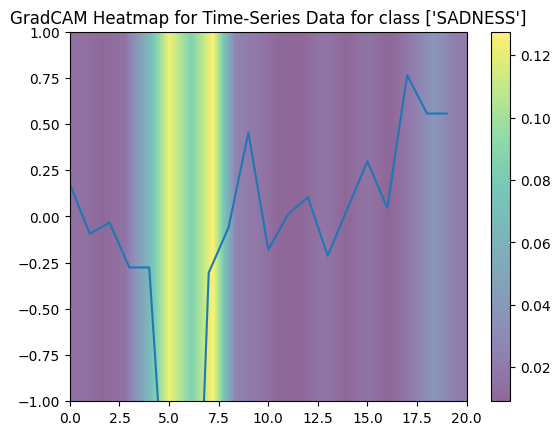

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
tf.Tensor(
[[0.11696777 0.0623     0.0119524  0.2157585  0.00947432 0.03935886
  0.01020022 0.18888831 0.19666137 0.14843823]], shape=(1, 10), dtype=float32)
(1, 18)
(20,)


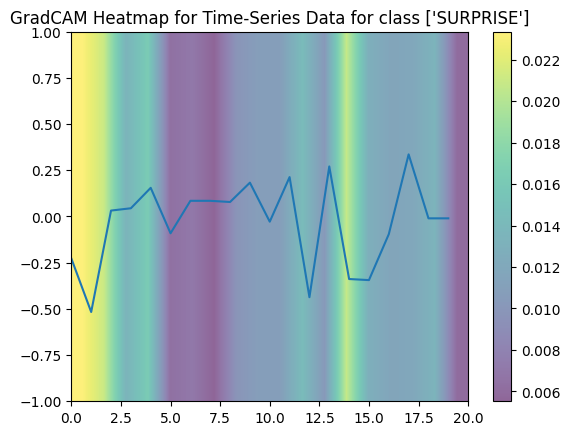

In [250]:
#Single Heatmap:

layer_names = [layer.name for layer in model.layers]

for i in range(1,10):
  id1 = find_first_index_by_class(y_train, i)
  if id1 == None:
    continue
  input_data = X_train[id1:id1+1]  # Use the first sample for demonstration
  layer_name = layer_names[0]  # Choose the appropriate layer name from your model
  cam = grad_cam(model, input_data, layer_name)

  tf.experimental.numpy.experimental_enable_numpy_behavior()

  plt.plot(X_train[id1, :, 0])
  print(y_train[id1])
  print(model(input_data))
  print(cam.shape)
  print(X_train[id1, :, 0].shape)
  # Plotting the GradCAM heatmap
  plt.imshow(cam[0, :, np.newaxis].T, cmap='viridis', alpha=0.6,
           extent=(0, sequence_length, -1, 1),
           interpolation='bilinear', aspect='auto')

  plt.title('GradCAM Heatmap for Time-Series Data for class ' + str(np.unique(y[id1])))
  plt.colorbar()
  plt.show()


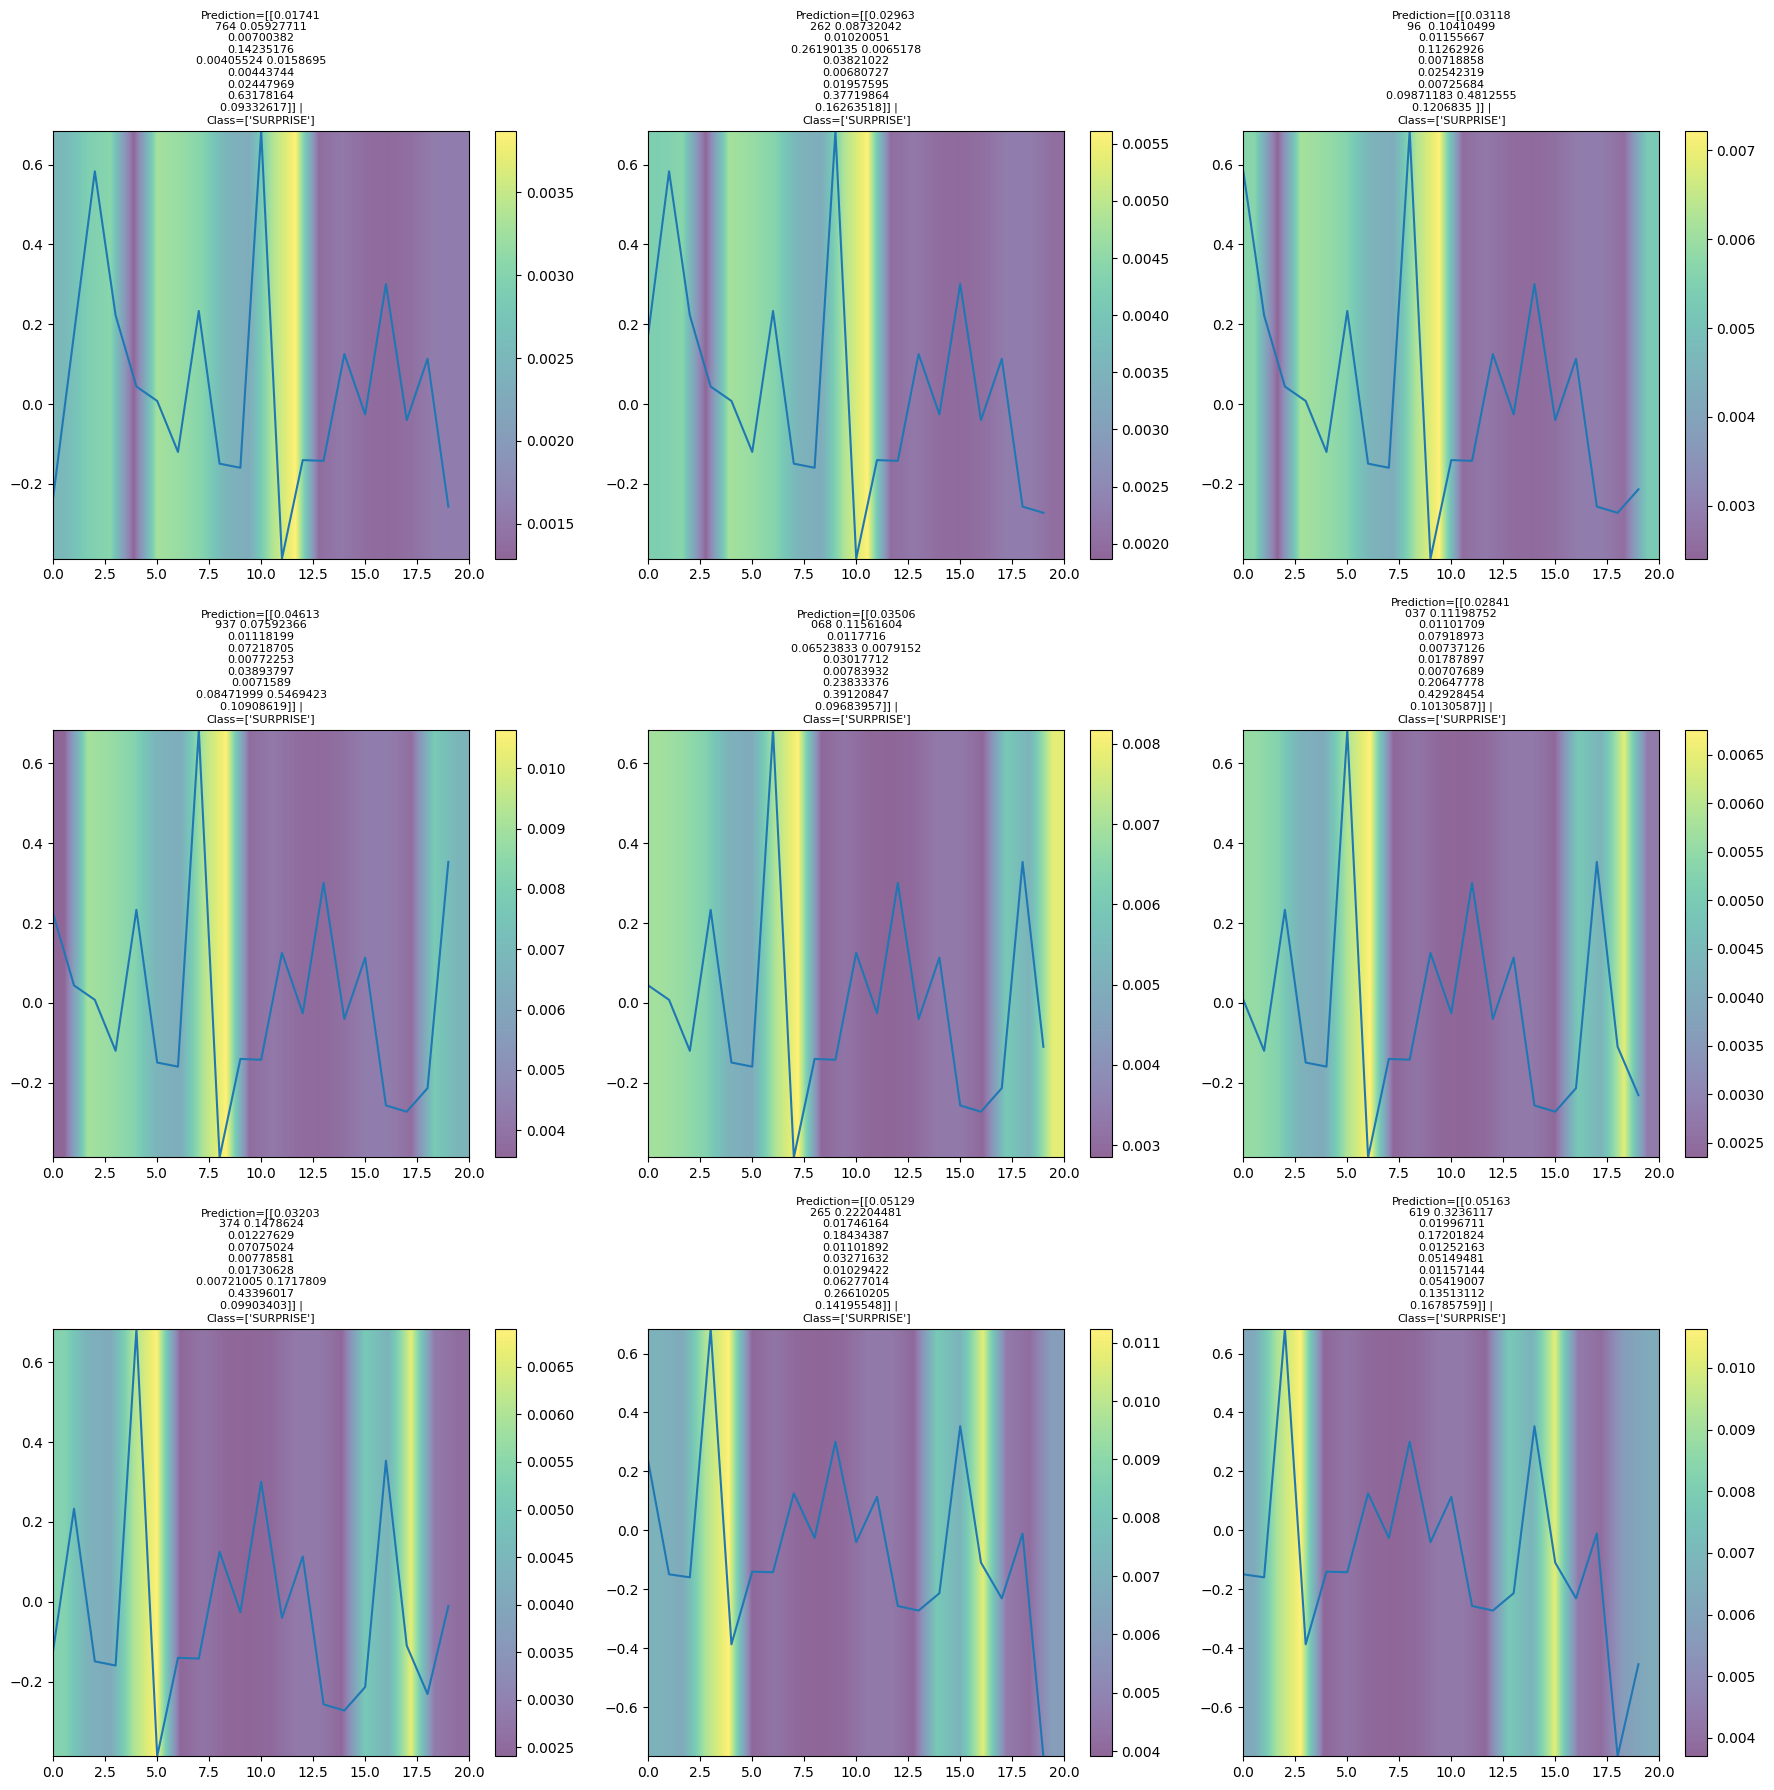

In [260]:
#Multiple heatmaps for col_nr x row_nr first instances from X_train:
import textwrap

layer_names=[layer.name for layer in model.layers]

layer_name = layer_names[0]


tf.experimental.numpy.experimental_enable_numpy_behavior()

#set number of subplots here:
col_nr = 3
row_nr = 3

fig, axs = plt.subplots(row_nr,col_nr)
fig.set_figwidth(col_nr*6)
fig.set_figheight(row_nr*6)


for i in range(0,row_nr):
  for j in range (0,col_nr):
    idx = i*col_nr+j
    input_data = X_train[idx:idx+1]
    prediction = model(input_data)
    cam = grad_cam(model, input_data, layer_name)
    axs[i][j].plot(X_train[idx,:,0])
    im = axs[i][j].imshow(cam[0, :, np.newaxis].T, cmap='viridis', alpha=0.6, extent=(0, sequence_length, min(X_train[idx,:,0]), max(X_train[idx,:,0])), interpolation='bilinear', aspect='auto')
    wrapped_title = textwrap.fill(f'Prediction={tf.keras.backend.get_value(prediction)} | Class={np.unique(y[id1])}', width=20)
    axs[i][j].set_title(wrapped_title, fontsize=8)
    plt.colorbar(im)

plt.tight_layout()
fig.show()

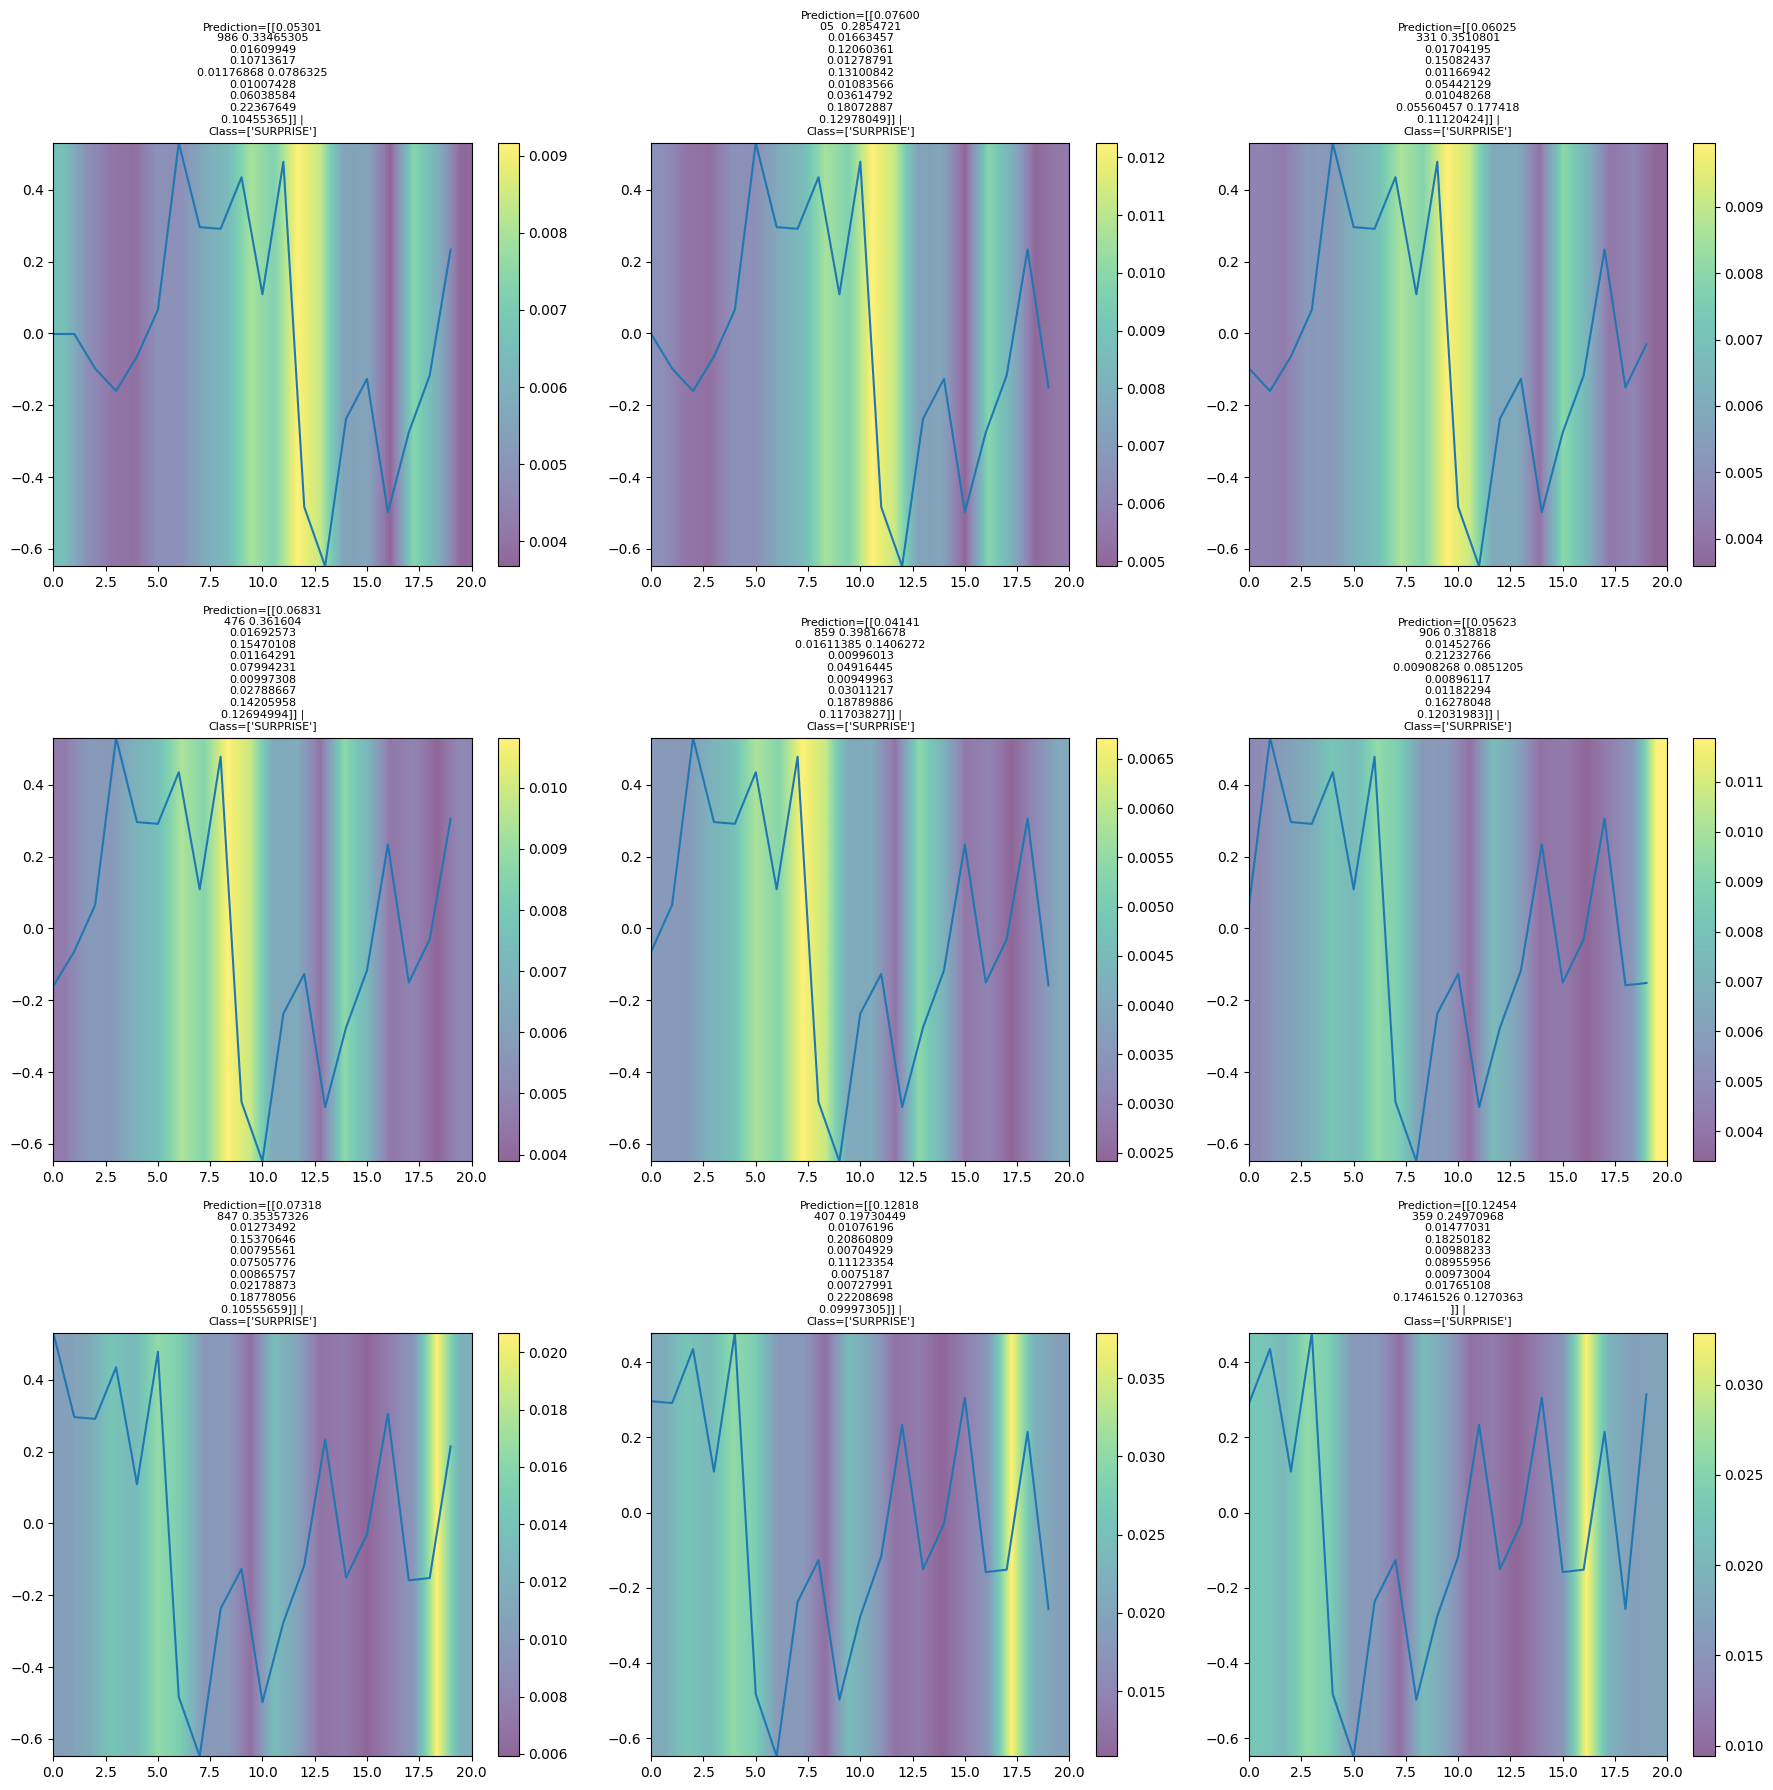

In [261]:
#Multiple heatmaps for col_nr x row_nr first instances from X_test:
import textwrap

layer_names=[layer.name for layer in model.layers]

layer_name = layer_names[0]


tf.experimental.numpy.experimental_enable_numpy_behavior()

#set number of subplots here:
col_nr = 3
row_nr = 3

fig, axs = plt.subplots(row_nr,col_nr)
fig.set_figwidth(col_nr*6)
fig.set_figheight(row_nr*6)


for i in range(0,row_nr):
  for j in range (0,col_nr):
    idx = i*col_nr+j
    input_data = X_test[idx:idx+1]
    prediction = model(input_data)
    cam = grad_cam(model, input_data, layer_name)
    axs[i][j].plot(X_test[idx,:,0])
    im = axs[i][j].imshow(cam[0, :, np.newaxis].T, cmap='viridis', alpha=0.6, extent=(0, sequence_length, min(X_test[idx,:,0]), max(X_test[idx,:,0])), interpolation='bilinear', aspect='auto')
    wrapped_title = textwrap.fill(f'Prediction={tf.keras.backend.get_value(prediction)} | Class={np.unique(y[id1])}', width=20)
    axs[i][j].set_title(wrapped_title, fontsize=8)
    plt.colorbar(im)

plt.tight_layout()
fig.show()